# Cryptocurrency : Analysis & Forecasting

## 1. Import libraries and set parameters

In [1]:
import random
import os
import numpy as np 
import pandas as pd 
import requests
import pandas_datareader as web


import datetime as dt
from datetime import date, timedelta, datetime


import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)


from tsfresh import extract_features, select_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.inspection import permutation_importance
import eli5
from eli5.sklearn import PermutationImportance
import shap


import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose



from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from prophet import Prophet
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

C:\Users\Narayana\anaconda3\envs\fts\lib\site-packages\tqdm\auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
# What EDA & FE techniques use?
is_anomalies = True

In [3]:
# What type of model to use?
is_Prophet = True  
is_ARIMA = True  
is_other_ML = True 

In [4]:
if is_ARIMA:
    !pip install pmdarima
    import pmdarima as pm

In [71]:
# Set random state
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

random_state = 42
fix_all_seeds(random_state)

In [72]:
cryptocurrency = 'BTC'
target = 'Close'
forecasting_days = 10 

In [73]:
date_start = dt.datetime(2020, 4, 1)
date_end = dt.datetime.now()
# date_end = dt.datetime(2022, 9, 30)
print(f"Time interval: from {date_start} to {date_end}")

Time interval: from 2020-04-01 00:00:00 to 2022-12-26 08:10:20.015149


## 2. Download data 

In [74]:
def get_data(cryptocurrency, date_start, date_end=None):
    
    if date_end is None:
        date_end = dt.datetime.now()
    df = web.DataReader(f'{cryptocurrency}-USD', 'yahoo', date_start, date_end)
    
    return df

df = get_data(cryptocurrency, date_start, date_end)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-03-31,6504.515137,6374.162109,6430.606445,6438.644531,32786468812,6438.644531
2020-04-01,6612.573730,6202.373535,6437.319336,6606.776367,40346426266,6606.776367
2020-04-02,7088.247559,6595.918457,6606.776367,6793.624512,47660646124,6793.624512
2020-04-03,7003.220703,6673.335938,6797.396484,6733.387207,38976504903,6733.387207
2020-04-04,6878.953613,6696.484863,6738.382812,6867.527344,33185988584,6867.527344
...,...,...,...,...,...,...
2022-12-22,16866.673828,16592.408203,16818.380859,16830.341797,16441573050,16830.341797
2022-12-23,16905.218750,16794.458984,16829.644531,16796.953125,15329265213,16796.953125
2022-12-24,16864.703125,16793.527344,16796.976562,16847.755859,9744636213,16847.755859


EDA

In [75]:
def c_chart(data,label):
    candlestick = go.Figure(data = [go.Candlestick(x=data.index,
                                                   open = data['Open'], 
                                                   high = data['High'], 
                                                   low = data['Low'], 
                                                   close = data['Close'])])
    candlestick.update_xaxes(title_text = 'Time',
                             rangeslider_visible = True)

    candlestick.update_layout(
    title = {
            'text': '{:} Candelstick Chart'.format(label),
            "y":0.8,
            "x":0.5,
            'xanchor': 'center',
            'yanchor': 'top'})

    candlestick.update_yaxes(title_text = 'Price in USD', ticksuffix = '$')
    return candlestick
%matplotlib inline
btc_candle=c_chart(df, label="BTC Price")
btc_candle.show()

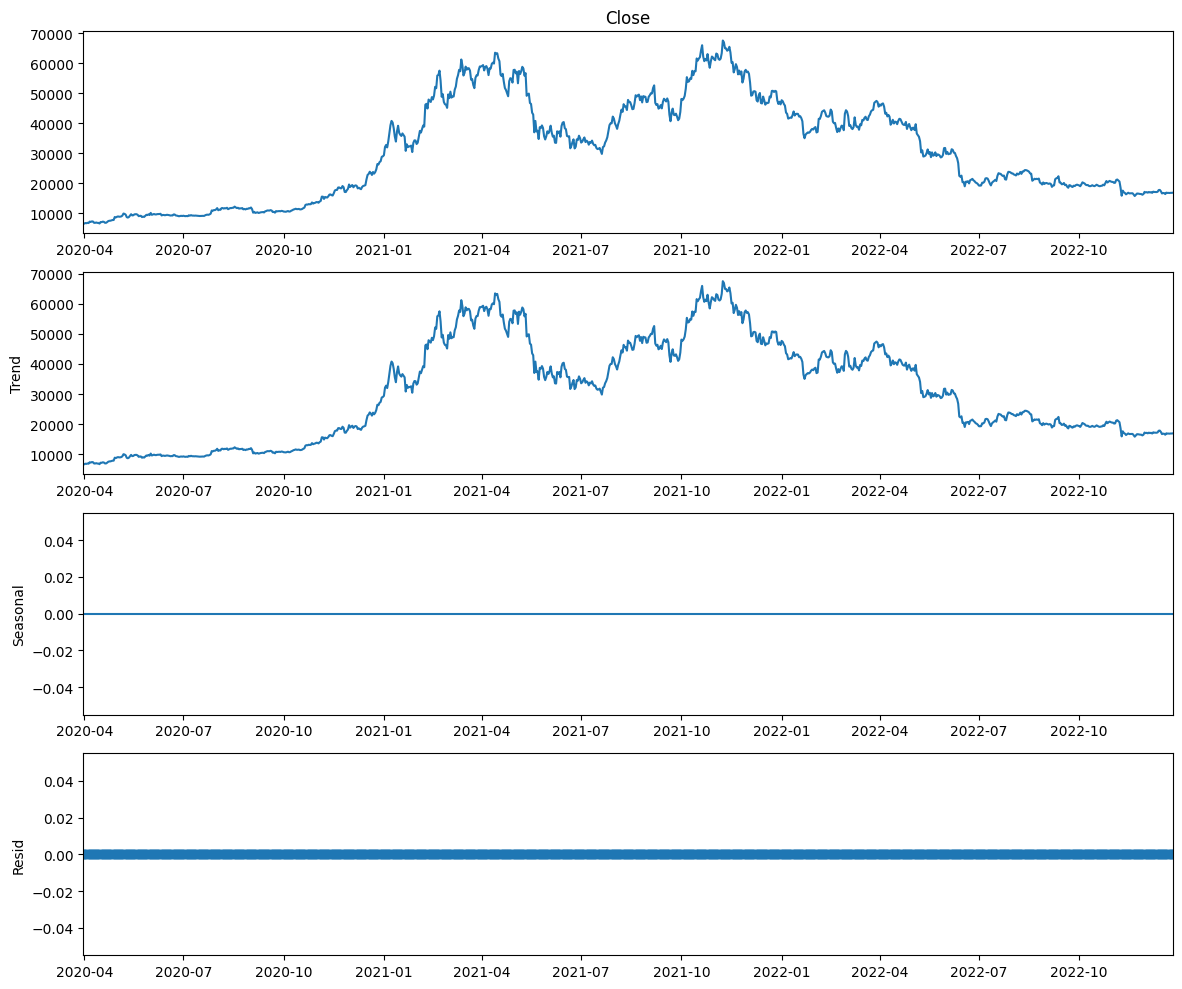

In [76]:
decomp = seasonal_decompose(df.Close, period=1)
fig = decomp.plot()
fig.set_size_inches((12, 10))
fig.tight_layout()
plt.show()

## 3. FE 

### 3.1. FE with TSFRESH

In [77]:
def get_tsfresh_features(data):
   
    data = data.reset_index(drop=False).reset_index(drop=False)
    data = data.dropna(axis=1, how='all')
    
    extracted_features = extract_features(data, column_id="Date", column_sort="Date")
    
    extracted_features_clean = extracted_features.dropna(axis=1, how='all').reset_index(drop=True)
    
    cols_std_zero  = []
    for col in extracted_features_clean.columns:
        if extracted_features_clean[col].std()==0:
            cols_std_zero.append(col)
    extracted_features_clean = extracted_features_clean.drop(columns = cols_std_zero)

    extracted_features_clean['Date'] = data['Date']   # For the merging
    
    return extracted_features_clean

In [78]:
%%time
extracted_features_clean = get_tsfresh_features(df[['Close']])
extracted_features_clean

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.25it/s]


Wall time: 19.1 s


,index__sum_values,index__abs_energy,index__median,index__mean,index__root_mean_square,index__maximum,index__absolute_maximum,index__minimum,index__benford_correlation,index__quantile__q_0.1,...,Close__quantile__q_0.7,Close__quantile__q_0.8,Close__quantile__q_0.9,"Close__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)","Close__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","Close__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","Close__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","Close__fft_coefficient__attr_""real""__coeff_0","Close__fft_coefficient__attr_""abs""__coeff_0",Date
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,6438.644531,6438.644531,6438.644531,3948.765569,2497.418629,1765.941648,1248.709314,6438.644531,6438.644531,2020-03-31
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.864123,1.0,...,6606.776367,6606.776367,6606.776367,4051.879385,2562.633532,1812.055548,1281.316766,6606.776367,6606.776367,2020-04-01
2,2.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,0.295657,2.0,...,6793.624512,6793.624512,6793.624512,4166.471752,2635.108109,1863.302813,1317.554054,6793.624512,6793.624512,2020-04-02
3,3.0,9.0,3.0,3.0,3.0,3.0,3.0,3.0,0.062915,3.0,...,6733.387207,6733.387207,6733.387207,4129.528729,2611.743289,1846.781391,1305.871645,6733.387207,6733.387207,2020-04-03
4,4.0,16.0,4.0,4.0,4.0,4.0,4.0,4.0,-0.064614,4.0,...,6867.527344,6867.527344,6867.527344,4211.795726,2663.773507,1883.572310,1331.886753,6867.527344,6867.527344,2020-04-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,996.0,992016.0,996.0,996.0,996.0,996.0,996.0,996.0,-0.297356,996.0,...,16830.341797,16830.341797,16830.341797,10321.904538,6528.145626,4616.096041,3264.072813,16830.341797,16830.341797,2022-12-22
997,997.0,994009.0,997.0,997.0,997.0,997.0,997.0,997.0,-0.297356,997.0,...,16796.953125,16796.953125,16796.953125,10301.427551,6515.194843,4606.938454,3257.597421,16796.953125,16796.953125,2022-12-23
998,998.0,996004.0,998.0,998.0,998.0,998.0,998.0,998.0,-0.297356,998.0,...,16847.755859,16847.755859,16847.755859,10332.584433,6534.900185,4620.872235,3267.450093,16847.755859,16847.755859,2022-12-24
999,999.0,998001.0,999.0,999.0,999.0,999.0,999.0,999.0,-0.297356,999.0,...,16841.986328,16841.986328,16841.986328,10329.046029,6532.662302,4619.289813,3266.331151,16841.986328,16841.986328,2022-12-25


In [79]:
extracted_features_clean.describe()

,index__sum_values,index__abs_energy,index__median,index__mean,index__root_mean_square,index__maximum,index__absolute_maximum,index__minimum,index__benford_correlation,index__quantile__q_0.1,...,Close__quantile__q_0.6,Close__quantile__q_0.7,Close__quantile__q_0.8,Close__quantile__q_0.9,"Close__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)","Close__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","Close__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","Close__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","Close__fft_coefficient__attr_""real""__coeff_0","Close__fft_coefficient__attr_""abs""__coeff_0"
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1000.000000,1001.000000,...,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,500.000000,333500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,0.000864,500.000000,...,30815.430932,30815.430932,30815.430932,30815.430932,18898.839977,11952.675892,8451.818177,5976.337946,30815.430932,30815.430932
std,289.108111,298608.206658,289.108111,289.108111,289.108111,289.108111,289.108111,289.108111,0.354608,289.108111,...,16673.116137,16673.116137,16673.116137,16673.116137,10225.479386,6467.161006,4572.973402,3233.580503,16673.116137,16673.116137
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.297356,0.000000,...,6438.644531,6438.644531,6438.644531,6438.644531,3948.765569,2497.418629,1765.941648,1248.709314,6438.644531,6438.644531
25%,250.000000,62500.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,-0.241690,250.000000,...,16757.976562,16757.976562,16757.976562,16757.976562,10277.523559,6500.076631,4596.248264,3250.038315,16757.976562,16757.976562
50%,500.000000,250000.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,-0.145280,500.000000,...,30314.333984,30314.333984,30314.333984,30314.333984,18591.521509,11758.310627,8314.381180,5879.155314,30314.333984,30314.333984
75%,750.000000,562500.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,0.062915,750.000000,...,44354.636719,44354.636719,44354.636719,44354.636719,27202.318975,17204.257120,12165.246875,8602.128560,44354.636719,44354.636719
max,1000.000000,1000000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,0.864123,1000.000000,...,67566.828125,67566.828125,67566.828125,67566.828125,41438.157243,26207.791786,18531.707291,13103.895893,67566.828125,67566.828125


In [80]:
extracted_features_clean.columns.tolist()

['index__sum_values',
 'index__abs_energy',
 'index__median',
 'index__mean',
 'index__root_mean_square',
 'index__maximum',
 'index__absolute_maximum',
 'index__minimum',
 'index__benford_correlation',
 'index__quantile__q_0.1',
 'index__quantile__q_0.2',
 'index__quantile__q_0.3',
 'index__quantile__q_0.4',
 'index__quantile__q_0.6',
 'index__quantile__q_0.7',
 'index__quantile__q_0.8',
 'index__quantile__q_0.9',
 'index__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)',
 'index__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)',
 'index__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)',
 'index__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)',
 'index__fft_coefficient__attr_"real"__coeff_0',
 'index__fft_coefficient__attr_"abs"__coeff_0',
 'index__value_count__value_0',
 'index__value_count__value_1',
 'index__range_count__max_1__min_-1',
 'index__count_below__t_0',
 'Close__sum_values',
 'Close__abs_energy',
 'Close__median',
 'Close__mean',
 'Close__root_

In [81]:
df = pd.merge(df, extracted_features_clean, how='left', on='Date')
df

,Date,High,Low,Open,Close,Volume,Adj Close,index__sum_values,index__abs_energy,index__median,...,Close__quantile__q_0.6,Close__quantile__q_0.7,Close__quantile__q_0.8,Close__quantile__q_0.9,"Close__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)","Close__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","Close__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","Close__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","Close__fft_coefficient__attr_""real""__coeff_0","Close__fft_coefficient__attr_""abs""__coeff_0"
0,2020-03-31,6504.515137,6374.162109,6430.606445,6438.644531,32786468812,6438.644531,0.0,0.0,0.0,...,6438.644531,6438.644531,6438.644531,6438.644531,3948.765569,2497.418629,1765.941648,1248.709314,6438.644531,6438.644531
1,2020-04-01,6612.573730,6202.373535,6437.319336,6606.776367,40346426266,6606.776367,1.0,1.0,1.0,...,6606.776367,6606.776367,6606.776367,6606.776367,4051.879385,2562.633532,1812.055548,1281.316766,6606.776367,6606.776367
2,2020-04-02,7088.247559,6595.918457,6606.776367,6793.624512,47660646124,6793.624512,2.0,4.0,2.0,...,6793.624512,6793.624512,6793.624512,6793.624512,4166.471752,2635.108109,1863.302813,1317.554054,6793.624512,6793.624512
3,2020-04-03,7003.220703,6673.335938,6797.396484,6733.387207,38976504903,6733.387207,3.0,9.0,3.0,...,6733.387207,6733.387207,6733.387207,6733.387207,4129.528729,2611.743289,1846.781391,1305.871645,6733.387207,6733.387207
4,2020-04-04,6878.953613,6696.484863,6738.382812,6867.527344,33185988584,6867.527344,4.0,16.0,4.0,...,6867.527344,6867.527344,6867.527344,6867.527344,4211.795726,2663.773507,1883.572310,1331.886753,6867.527344,6867.527344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,2022-12-22,16866.673828,16592.408203,16818.380859,16830.341797,16441573050,16830.341797,996.0,992016.0,996.0,...,16830.341797,16830.341797,16830.341797,16830.341797,10321.904538,6528.145626,4616.096041,3264.072813,16830.341797,16830.341797
997,2022-12-23,16905.218750,16794.458984,16829.644531,16796.953125,15329265213,16796.953125,997.0,994009.0,997.0,...,16796.953125,16796.953125,16796.953125,16796.953125,10301.427551,6515.194843,4606.938454,3257.597421,16796.953125,16796.953125
998,2022-12-24,16864.703125,16793.527344,16796.976562,16847.755859,9744636213,16847.755859,998.0,996004.0,998.0,...,16847.755859,16847.755859,16847.755859,16847.755859,10332.584433,6534.900185,4620.872235,3267.450093,16847.755859,16847.755859
999,2022-12-25,16860.554688,16755.253906,16847.505859,16841.986328,11656379938,16841.986328,999.0,998001.0,999.0,...,16841.986328,16841.986328,16841.986328,16841.986328,10329.046029,6532.662302,4619.289813,3266.331151,16841.986328,16841.986328


In [15]:
df.shape

(1000, 57)

### 3.2. FE from technical features

In [85]:
def get_add_features(df_feat):

    df_feat['Upper_Shadow'] = df_feat['High'] - np.maximum(df_feat['Close'], df_feat['Open'])
    df_feat['Lower_Shadow'] = np.minimum(df_feat['Close'], df_feat['Open']) - df_feat['Low']
    
    df_feat['lower_shadow'] = np.minimum(df_feat['Close'], df_feat['Open']) - df_feat['Low']
    df_feat['high2low'] = (df_feat['High'] / df_feat['Low']).replace([np.inf, -np.inf, np.nan], 0.)
    
    return df_feat

In [86]:
# FE - add features
df = get_add_features(df)
df

,Date,High,Low,Open,Close,Volume,Adj Close,index__sum_values,index__abs_energy,index__median,...,"Close__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","Close__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","Close__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","Close__fft_coefficient__attr_""real""__coeff_0","Close__fft_coefficient__attr_""abs""__coeff_0",Close_diff_anomalous,Upper_Shadow,Lower_Shadow,lower_shadow,high2low
0,2020-03-31,6504.515137,6374.162109,6430.606445,6438.644531,32786468812,6438.644531,0.0,0.0,0.0,...,2497.418629,1765.941648,1248.709314,6438.644531,6438.644531,0,65.870605,56.444336,56.444336,1.020450
1,2020-04-01,6612.573730,6202.373535,6437.319336,6606.776367,40346426266,6606.776367,1.0,1.0,1.0,...,2562.633532,1812.055548,1281.316766,6606.776367,6606.776367,0,5.797363,234.945801,234.945801,1.066136
2,2020-04-02,7088.247559,6595.918457,6606.776367,6793.624512,47660646124,6793.624512,2.0,4.0,2.0,...,2635.108109,1863.302813,1317.554054,6793.624512,6793.624512,0,294.623047,10.857910,10.857910,1.074641
3,2020-04-03,7003.220703,6673.335938,6797.396484,6733.387207,38976504903,6733.387207,3.0,9.0,3.0,...,2611.743289,1846.781391,1305.871645,6733.387207,6733.387207,0,205.824219,60.051270,60.051270,1.049433
4,2020-04-04,6878.953613,6696.484863,6738.382812,6867.527344,33185988584,6867.527344,4.0,16.0,4.0,...,2663.773507,1883.572310,1331.886753,6867.527344,6867.527344,0,11.426270,41.897949,41.897949,1.027248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,2022-12-22,16866.673828,16592.408203,16818.380859,16830.341797,16441573050,16830.341797,996.0,992016.0,996.0,...,6528.145626,4616.096041,3264.072813,16830.341797,16830.341797,0,36.332031,225.972656,225.972656,1.016530
997,2022-12-23,16905.218750,16794.458984,16829.644531,16796.953125,15329265213,16796.953125,997.0,994009.0,997.0,...,6515.194843,4606.938454,3257.597421,16796.953125,16796.953125,0,75.574219,2.494141,2.494141,1.006595
998,2022-12-24,16864.703125,16793.527344,16796.976562,16847.755859,9744636213,16847.755859,998.0,996004.0,998.0,...,6534.900185,4620.872235,3267.450093,16847.755859,16847.755859,0,16.947266,3.449219,3.449219,1.004238
999,2022-12-25,16860.554688,16755.253906,16847.505859,16841.986328,11656379938,16841.986328,999.0,998001.0,999.0,...,6532.662302,4619.289813,3266.331151,16841.986328,16841.986328,0,13.048828,86.732422,86.732422,1.006285


In [87]:
if is_anomalies:
    anomalous_dates = ['2021-01-08', '2021-01-27', '2021-04-13', '2021-07-20',
                       '2021-09-06', '2021-09-29', '2021-11-08', '2021-12-17']
    holidays_df = pd.DataFrame(columns = ['ds', 'lower_window', 'upper_window', 'prior_scale'])
    holidays_df['ds'] = anomalous_dates
    holidays_df['holiday'] = 'anomalous_dates'
    holidays_df['lower_window'] = 0
    holidays_df['upper_window'] = 0
    holidays_df['prior_scale'] = 10
    display(holidays_df)

,ds,lower_window,upper_window,prior_scale,holiday
0,2021-01-08,0,0,10,anomalous_dates
1,2021-01-27,0,0,10,anomalous_dates
2,2021-04-13,0,0,10,anomalous_dates
3,2021-07-20,0,0,10,anomalous_dates
4,2021-09-06,0,0,10,anomalous_dates
5,2021-09-29,0,0,10,anomalous_dates
6,2021-11-08,0,0,10,anomalous_dates
7,2021-12-17,0,0,10,anomalous_dates


In [88]:
if is_anomalies:
    anomalous_dates_diff = anomalous_dates.copy()
    anomalous_dates_diff.append('2021-02-08')
    anomalous_dates_diff.append('2021-05-12')
    anomalous_dates_diff.append('2021-09-07')
    print(anomalous_dates_diff)

['2021-01-08', '2021-01-27', '2021-04-13', '2021-07-20', '2021-09-06', '2021-09-29', '2021-11-08', '2021-12-17', '2021-02-08', '2021-05-12', '2021-09-07']


In [89]:
if is_anomalies:
    df['Close_diff_anomalous'] = df['Date'].isin(anomalous_dates_diff).astype('int')    
    display(df)    
    print(f"Number of anomalous dates - {df['Close_diff_anomalous'].sum()}")

,Date,High,Low,Open,Close,Volume,Adj Close,index__sum_values,index__abs_energy,index__median,...,"Close__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","Close__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","Close__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","Close__fft_coefficient__attr_""real""__coeff_0","Close__fft_coefficient__attr_""abs""__coeff_0",Close_diff_anomalous,Upper_Shadow,Lower_Shadow,lower_shadow,high2low
0,2020-03-31,6504.515137,6374.162109,6430.606445,6438.644531,32786468812,6438.644531,0.0,0.0,0.0,...,2497.418629,1765.941648,1248.709314,6438.644531,6438.644531,0,65.870605,56.444336,56.444336,1.020450
1,2020-04-01,6612.573730,6202.373535,6437.319336,6606.776367,40346426266,6606.776367,1.0,1.0,1.0,...,2562.633532,1812.055548,1281.316766,6606.776367,6606.776367,0,5.797363,234.945801,234.945801,1.066136
2,2020-04-02,7088.247559,6595.918457,6606.776367,6793.624512,47660646124,6793.624512,2.0,4.0,2.0,...,2635.108109,1863.302813,1317.554054,6793.624512,6793.624512,0,294.623047,10.857910,10.857910,1.074641
3,2020-04-03,7003.220703,6673.335938,6797.396484,6733.387207,38976504903,6733.387207,3.0,9.0,3.0,...,2611.743289,1846.781391,1305.871645,6733.387207,6733.387207,0,205.824219,60.051270,60.051270,1.049433
4,2020-04-04,6878.953613,6696.484863,6738.382812,6867.527344,33185988584,6867.527344,4.0,16.0,4.0,...,2663.773507,1883.572310,1331.886753,6867.527344,6867.527344,0,11.426270,41.897949,41.897949,1.027248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,2022-12-22,16866.673828,16592.408203,16818.380859,16830.341797,16441573050,16830.341797,996.0,992016.0,996.0,...,6528.145626,4616.096041,3264.072813,16830.341797,16830.341797,0,36.332031,225.972656,225.972656,1.016530
997,2022-12-23,16905.218750,16794.458984,16829.644531,16796.953125,15329265213,16796.953125,997.0,994009.0,997.0,...,6515.194843,4606.938454,3257.597421,16796.953125,16796.953125,0,75.574219,2.494141,2.494141,1.006595
998,2022-12-24,16864.703125,16793.527344,16796.976562,16847.755859,9744636213,16847.755859,998.0,996004.0,998.0,...,6534.900185,4620.872235,3267.450093,16847.755859,16847.755859,0,16.947266,3.449219,3.449219,1.004238
999,2022-12-25,16860.554688,16755.253906,16847.505859,16841.986328,11656379938,16841.986328,999.0,998001.0,999.0,...,6532.662302,4619.289813,3266.331151,16841.986328,16841.986328,0,13.048828,86.732422,86.732422,1.006285


Number of anomalous dates - 11


### 3.4. Get target, training, validation and test datasets for ML models

In [23]:
def cut_data(df, y, num_start, num_end):
    df2 = df[num_start:(num_end+1)]
    y2 = y[num_start:(num_end+1)] if y is not None else None
    return df2, y2

In [24]:
def get_target_mf(df, forecasting_days, col='Close'):

    col_diff = f"{col}_diff"
    df[col_diff] = df['Close'].diff()
    df['target'] = df[col_diff].shift(-forecasting_days)
    df = df.drop(columns=[col_diff]).dropna()
    
    return df

In [25]:
def get_train_valid_test_ts(df, forecasting_days, target='Close'):
    # Get training, validation and test datasets with target for Time Series models

    df = df.dropna(how="any").reset_index(drop=True)
    df = df[['Date', 'Close']]
    df.columns = ['ds', 'y']        
    y = None
    
    N = len(df)
    train, _ = cut_data(df, y, 0, N-2*forecasting_days-1)
    valid, _ = cut_data(df, y, N-2*forecasting_days, N-forecasting_days-1)
    test, _ = cut_data(df, y, N-forecasting_days, N)
    
    train_valid = pd.concat([train, valid])

    print(f'Origin dataset has {len(df)} rows and {len(df.columns)} features')
    print(f'Get training dataset with {len(train)} rows')
    print(f'Get validation dataset with {len(valid)} rows')
    print(f'Get test dataset with {len(test)} rows')
    
    return train, valid, test, train_valid

In [35]:
def get_train_valid_test_mf(df, forecasting_days, target='target'):
    # Get training, validation and test datasets with target for multi-features ML models
    
    df = df.drop(columns = ['Date']).dropna(how="any").reset_index(drop=True)
    
    y = df.pop(target)

    N = len(df)
    start_points = {'valid_start_point' : df.loc[N-forecasting_days-1, 'Close'],
                    'test_start_point' : df.loc[N-1, 'Close']}

    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
    
    
    train, ytrain = cut_data(df.copy(), y, 0, N-2*forecasting_days-1)
    valid, yvalid = cut_data(df.copy(), y, N-2*forecasting_days, N-forecasting_days-1)
    test, ytest = cut_data(df.copy(), y, N-forecasting_days, N)


    train_valid = pd.concat([train, valid])
    y_train_valid = pd.concat([ytrain, yvalid])

    print(f'Origin dataset has {len(df)} rows and {len(df.columns)} features')
    print(f'Get training dataset with {len(train)} rows')
    print(f'Get validation dataset with {len(valid)} rows')
    print(f'Get test dataset with {len(test)} rows')
    
    return train, ytrain, valid, yvalid, test, ytest, train_valid, y_train_valid, start_points

## 4. Model training and forecasting 

In [36]:
def calc_metrics(type_score, list_true, list_pred):
    # Calculation score with type=type_score for list_true and list_pred 
    if type_score=='r2_score':
        score = r2_score(list_true, list_pred)
    elif type_score=='rmse':
        score = mean_squared_error(list_true, list_pred, squared=False)
    elif type_score=='mape':
        score = mean_absolute_percentage_error(list_true, list_pred)
    return score

In [37]:
def result_add_metrics(result, n, y_true, y_pred):
    # Calculation and addition metrics into dataframe result[n,:]
    
    result.loc[n,'r2_score'] = calc_metrics('r2_score', y_true, y_pred)
    result.loc[n,'rmse'] = calc_metrics('rmse', y_true, y_pred)      # in coins
    result.loc[n,'mape'] = 100*calc_metrics('mape', y_true, y_pred)  # in %
    
    return result

In [38]:
# Results of all models
result = pd.DataFrame(columns = ['name_model', 'type_data', 'r2_score', 'rmse', 'mape', 'params', 'ypred'])

### 4.1. Facebook Prophet 

In [39]:
if is_Prophet:
    df2 = df[df.Date.dt.year == 2021]
    display(df2)

,Date,High,Low,Open,Close,Volume,Adj Close,index__sum_values,index__abs_energy,index__median,...,"Adj Close__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","Adj Close__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","Adj Close__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","Adj Close__fft_coefficient__attr_""real""__coeff_0","Adj Close__fft_coefficient__attr_""abs""__coeff_0",Upper_Shadow,Lower_Shadow,lower_shadow,high2low,Close_diff_anomalous
276,2021-01-01,29600.626953,28803.585938,28994.009766,29374.152344,4.073030e+10,29374.152344,276.0,76176.0,276.0,...,11393.633383,8056.515427,5696.816691,29374.152344,29374.152344,226.474609,190.423828,190.423828,1.027672,0
277,2021-01-02,33155.117188,29091.181641,29376.455078,32127.267578,6.786542e+10,32127.267578,277.0,76729.0,277.0,...,12461.510518,8811.618591,6230.755259,32127.267578,32127.267578,1027.849609,285.273438,285.273438,1.139696,0
278,2021-01-03,34608.558594,32052.316406,32129.408203,32782.023438,7.866524e+10,32782.023438,278.0,77284.0,278.0,...,12715.476934,8991.199966,6357.738467,32782.023438,32782.023438,1826.535156,77.091797,77.091797,1.079752,0
279,2021-01-04,33440.218750,28722.755859,32810.949219,31971.914062,8.116348e+10,31971.914062,279.0,77841.0,279.0,...,12401.252064,8769.009430,6200.626032,31971.914062,31971.914062,629.269531,3249.158203,3249.158203,1.164241,0
280,2021-01-05,34437.589844,30221.187500,31977.041016,33992.429688,6.754732e+10,33992.429688,280.0,78400.0,280.0,...,13184.968782,9323.180836,6592.484391,33992.429688,33992.429688,445.160156,1755.853516,1755.853516,1.139518,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,2021-12-27,51956.328125,50499.468750,50802.609375,50640.417969,2.432435e+10,50640.417969,636.0,404496.0,636.0,...,19642.383206,13889.262364,9821.191603,50640.417969,50640.417969,1153.718750,140.949219,140.949219,1.028849,0
637,2021-12-28,50679.859375,47414.210938,50679.859375,47588.855469,3.343038e+10,47588.855469,637.0,405769.0,637.0,...,18458.744476,13052.303391,9229.372238,47588.855469,47588.855469,0.000000,174.644531,174.644531,1.068875,0
638,2021-12-29,48119.742188,46201.496094,47623.871094,46444.710938,3.004923e+10,46444.710938,638.0,407044.0,638.0,...,18014.954195,12738.496274,9007.477098,46444.710938,46444.710938,495.871094,243.214844,243.214844,1.041519,0
639,2021-12-30,47879.964844,46060.312500,46490.605469,47178.125000,2.668649e+10,47178.125000,639.0,408321.0,639.0,...,18299.430522,12939.651414,9149.715261,47178.125000,47178.125000,701.839844,430.292969,430.292969,1.039506,0


In [40]:
# Get datasets
if is_Prophet:
    train_ts, valid_ts, test_ts, train_valid_ts = get_train_valid_test_ts(df2.copy(), forecasting_days, target='Close')
    
    if not is_anomalies:
        holidays_df = None

Origin dataset has 365 rows and 2 features
Get training dataset with 345 rows
Get validation dataset with 10 rows
Get test dataset with 10 rows


In [43]:
def prophet_modeling(result, 
                     cryptocurrency, 
                     train, 
                     test, 
                     holidays_df, 
                     period_days,
                     fourier_order_seasonality,
                     forecasting_period,
                     name_model,
                     type_data):
    model = Prophet(daily_seasonality=False, 
                    weekly_seasonality=False, 
                    yearly_seasonality=False, 
                    changepoint_range=1, 
                    changepoint_prior_scale = 0.5, 
                    holidays=holidays_df, 
                    seasonality_mode = 'multiplicative'
                   )
    model.add_seasonality(name='seasonality', period=period_days, 
                          fourier_order=fourier_order_seasonality, 
                          mode = 'multiplicative', prior_scale = 0.5)
    model.fit(train)
    
    future = model.make_future_dataframe(periods = forecasting_period)
    forecast = model.predict(future)
    
    figure = model.plot(forecast, xlabel = 'Date', ylabel = f"{name_model} for {cryptocurrency}")
    
    figure_component = model.plot_components(forecast)
    
    ypred = forecast['yhat'][-forecasting_period:]
    n = len(result)
    result.loc[n,'name_model'] = f"Prophet_{name_model}"
    result.loc[n,'type_data'] = type_data
    result.at[n,'params'] = [period_days]+[fourier_order_seasonality]
    result.at[n,'ypred'] = ypred    
    return result, ypred

07:21:21 - cmdstanpy - INFO - Chain [1] start processing
07:21:22 - cmdstanpy - INFO - Chain [1] done processing
07:21:22 - cmdstanpy - INFO - Chain [1] start processing
07:21:22 - cmdstanpy - INFO - Chain [1] done processing
07:21:23 - cmdstanpy - INFO - Chain [1] start processing
07:21:23 - cmdstanpy - INFO - Chain [1] done processing
07:21:24 - cmdstanpy - INFO - Chain [1] start processing
07:21:24 - cmdstanpy - INFO - Chain [1] done processing
07:21:25 - cmdstanpy - INFO - Chain [1] start processing
07:21:25 - cmdstanpy - INFO - Chain [1] done processing
07:21:25 - cmdstanpy - INFO - Chain [1] start processing
07:21:25 - cmdstanpy - INFO - Chain [1] done processing
07:21:26 - cmdstanpy - INFO - Chain [1] start processing
07:21:26 - cmdstanpy - INFO - Chain [1] done processing
07:21:27 - cmdstanpy - INFO - Chain [1] start processing
07:21:27 - cmdstanpy - INFO - Chain [1] done processing


Wall time: 6.2 s


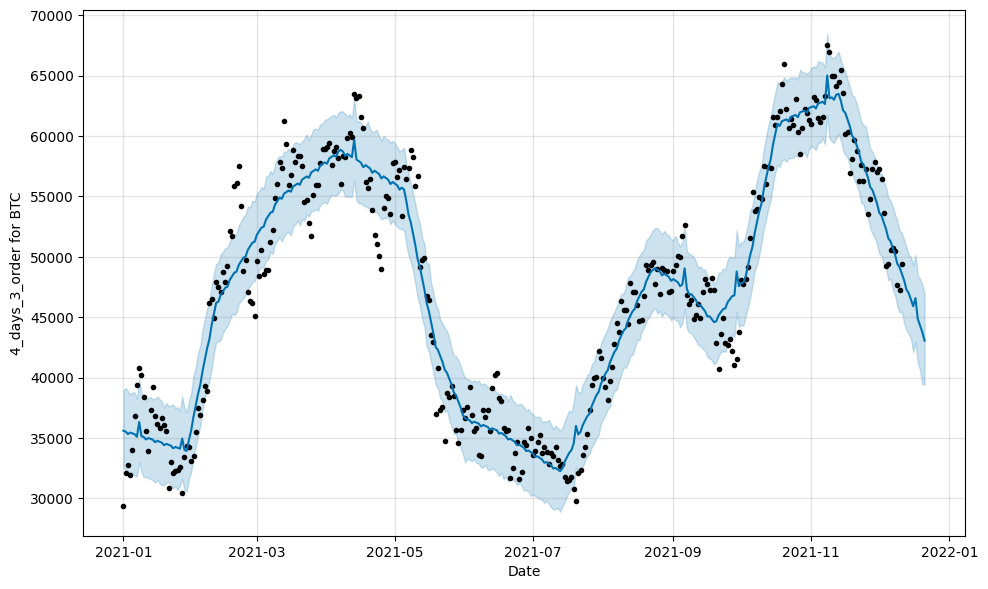

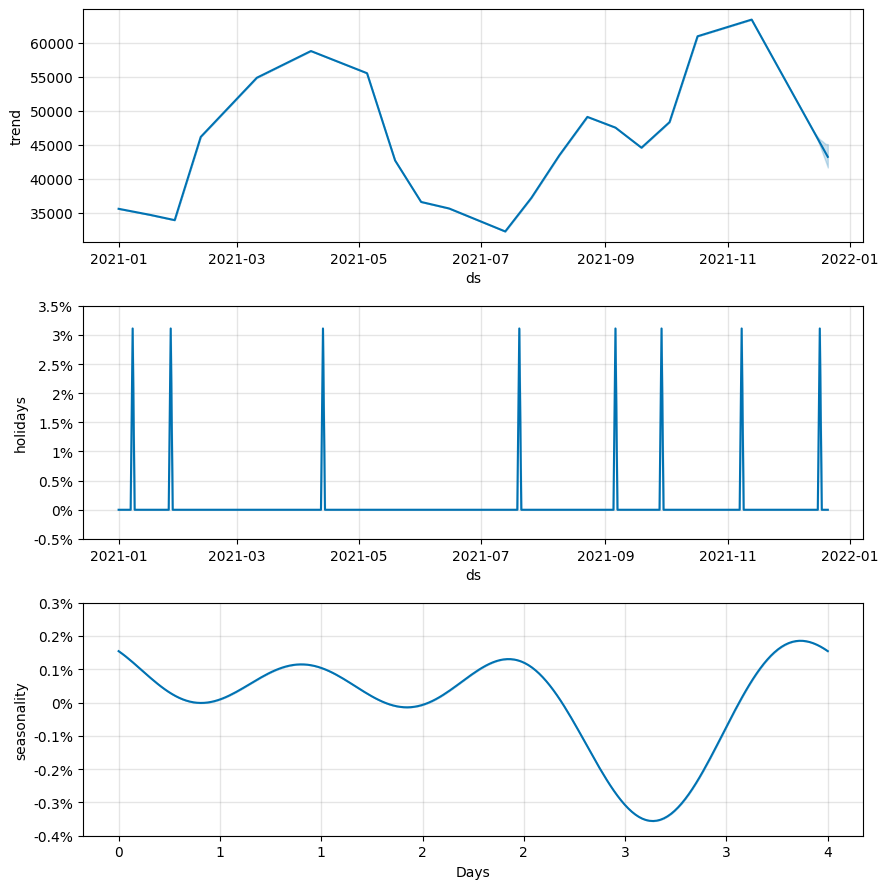

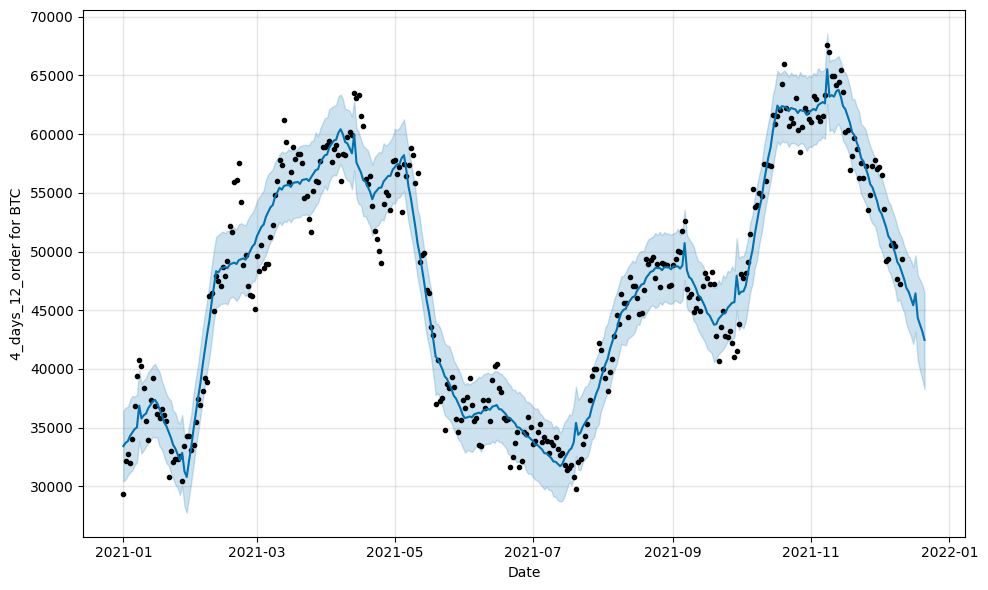

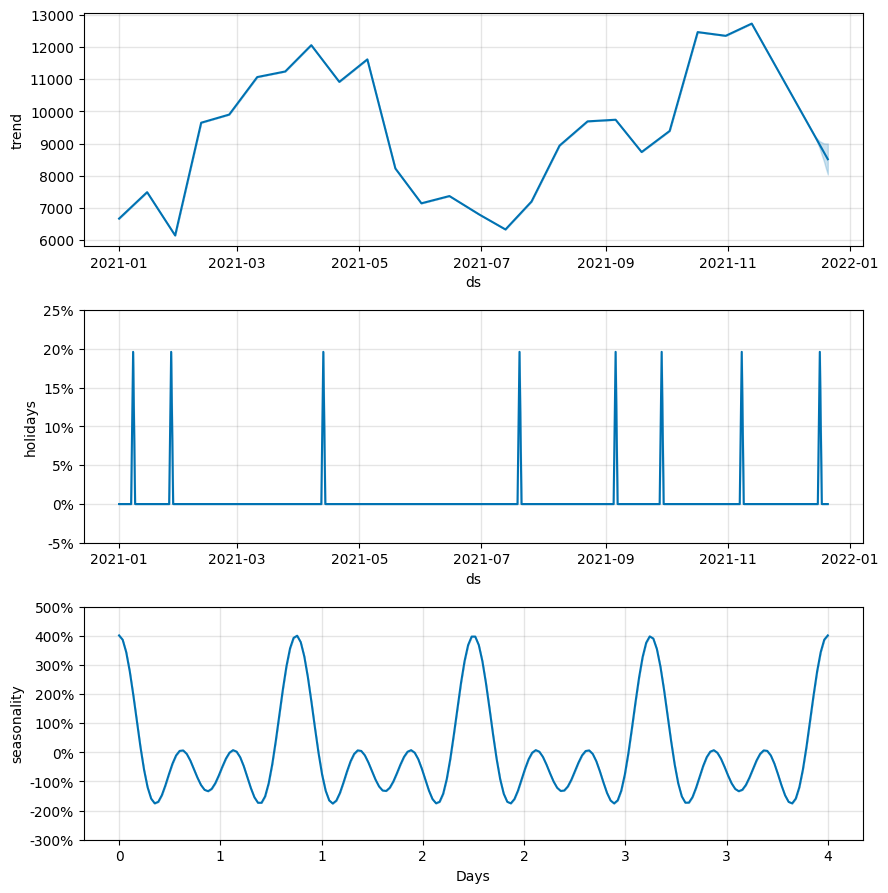

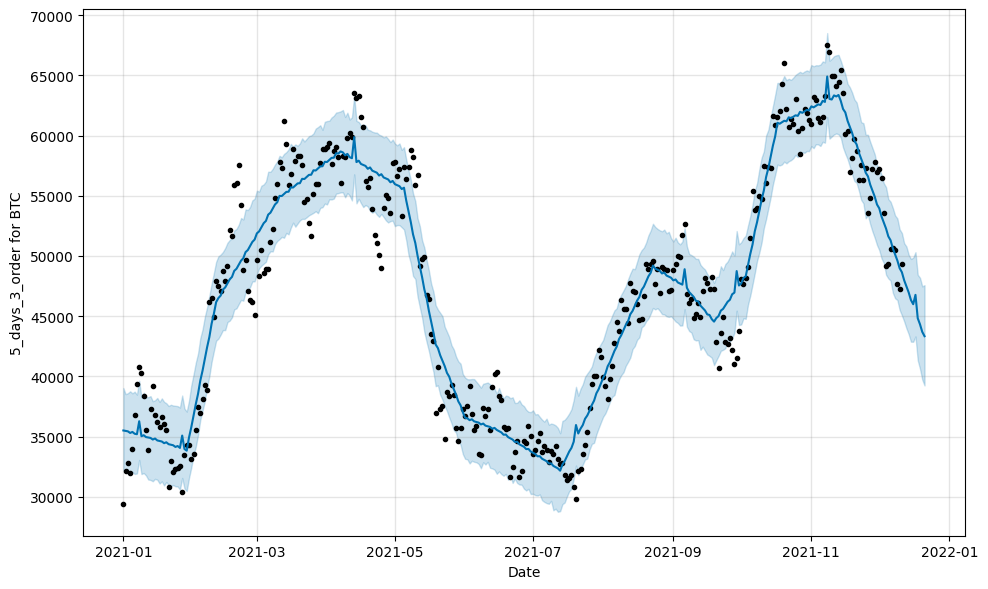

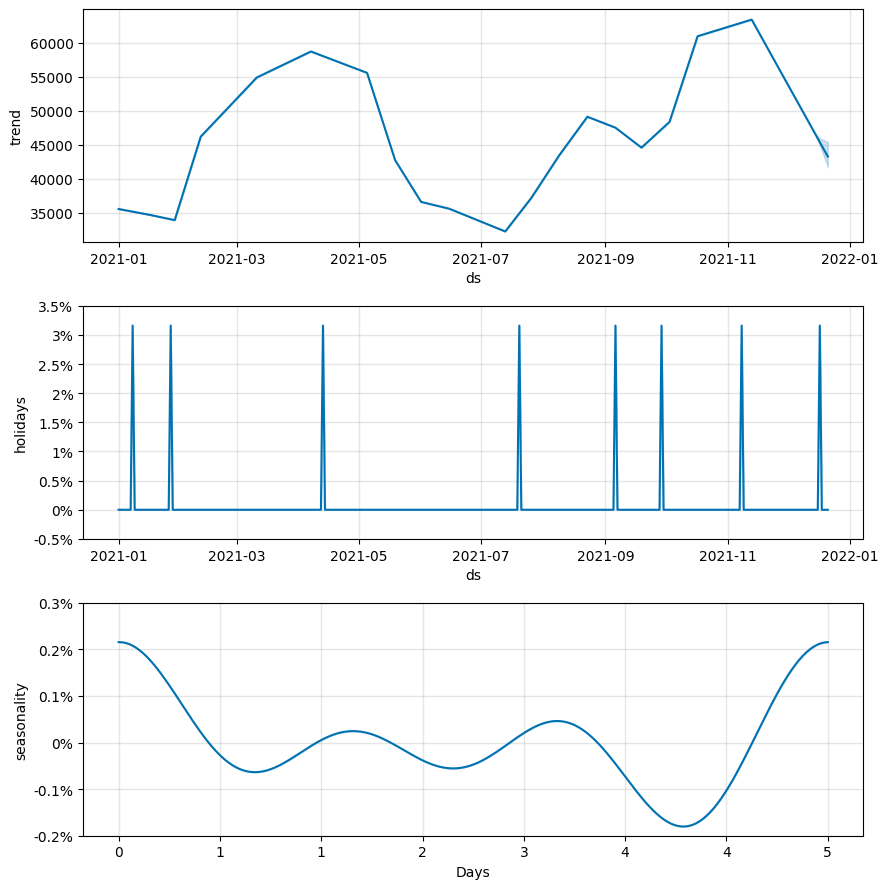

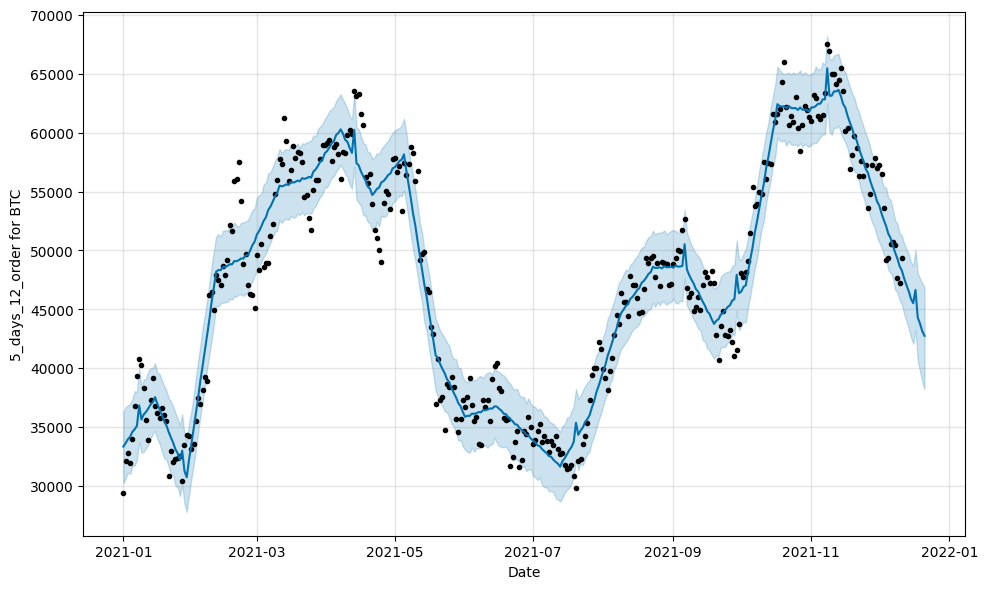

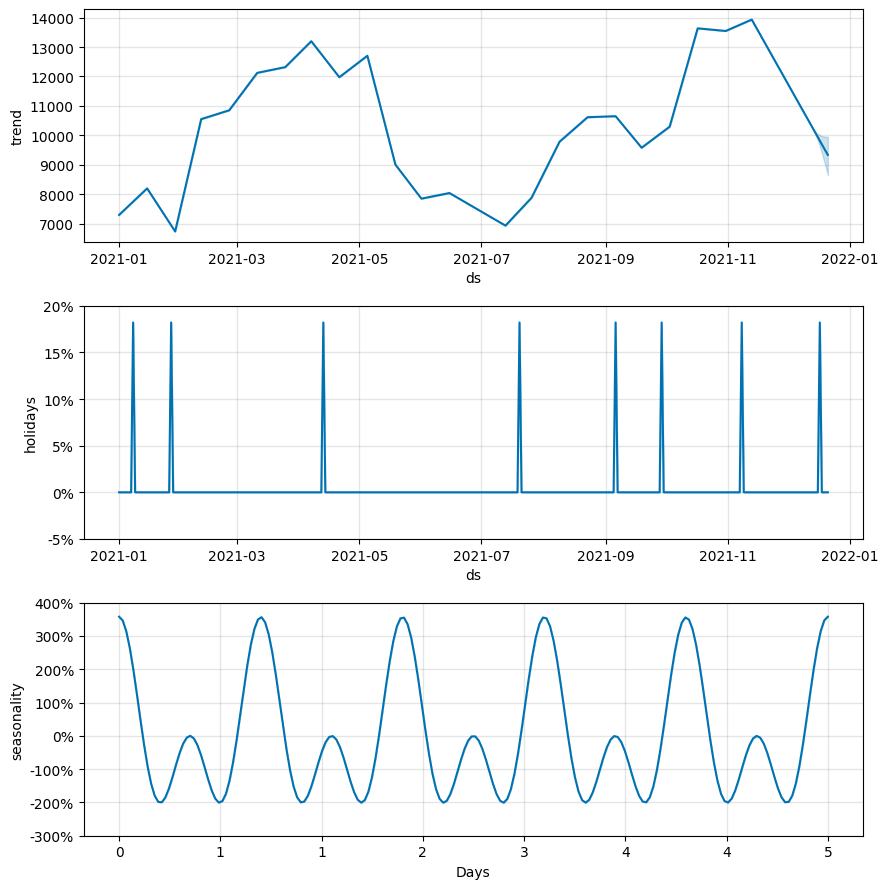

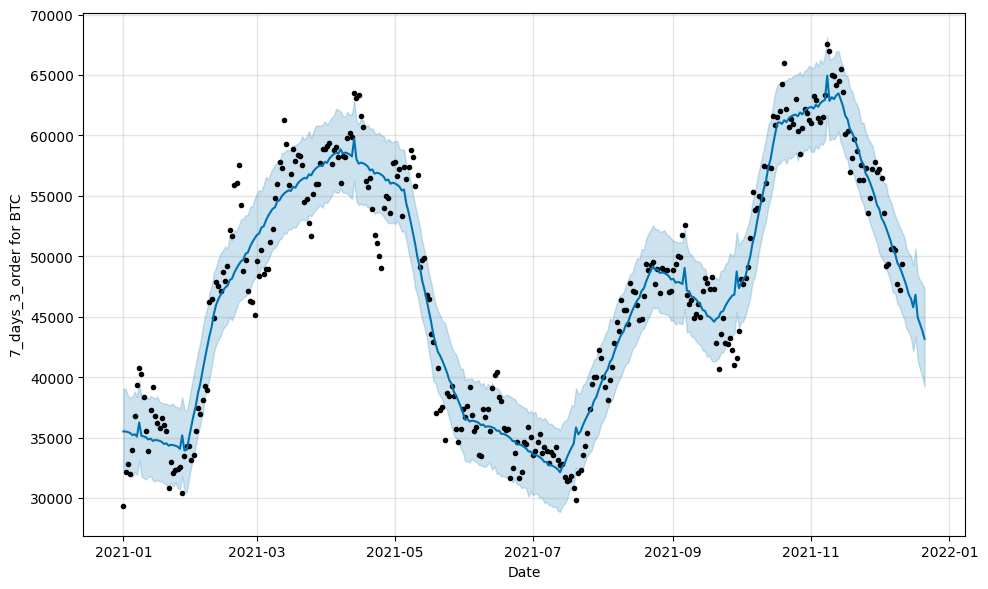

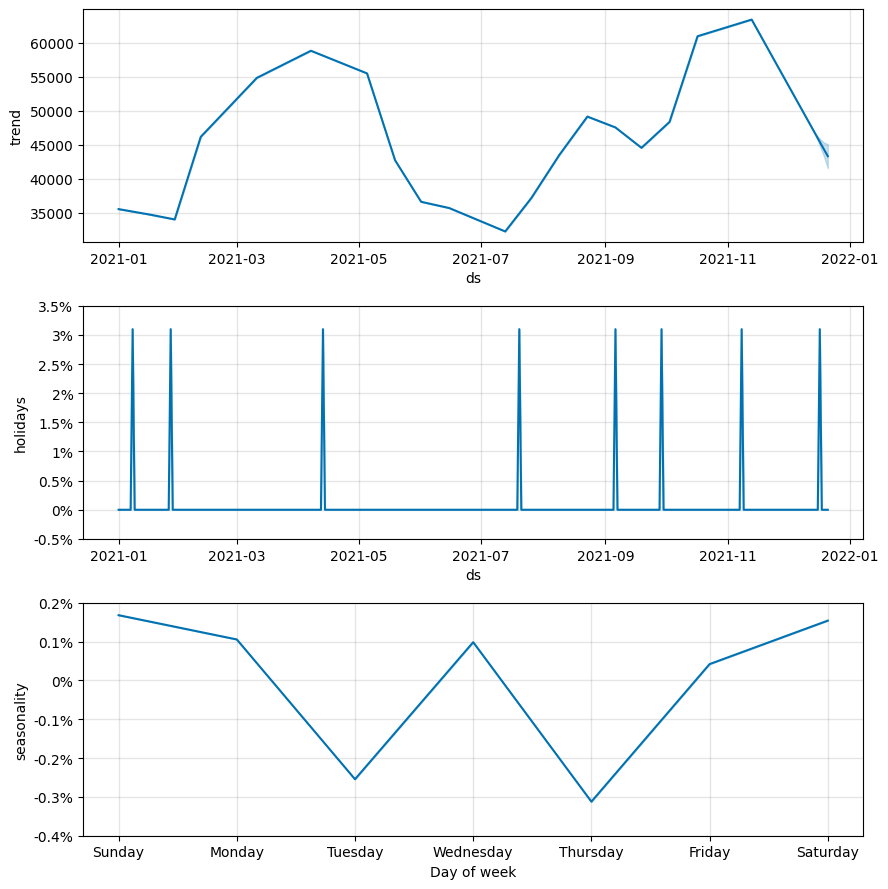

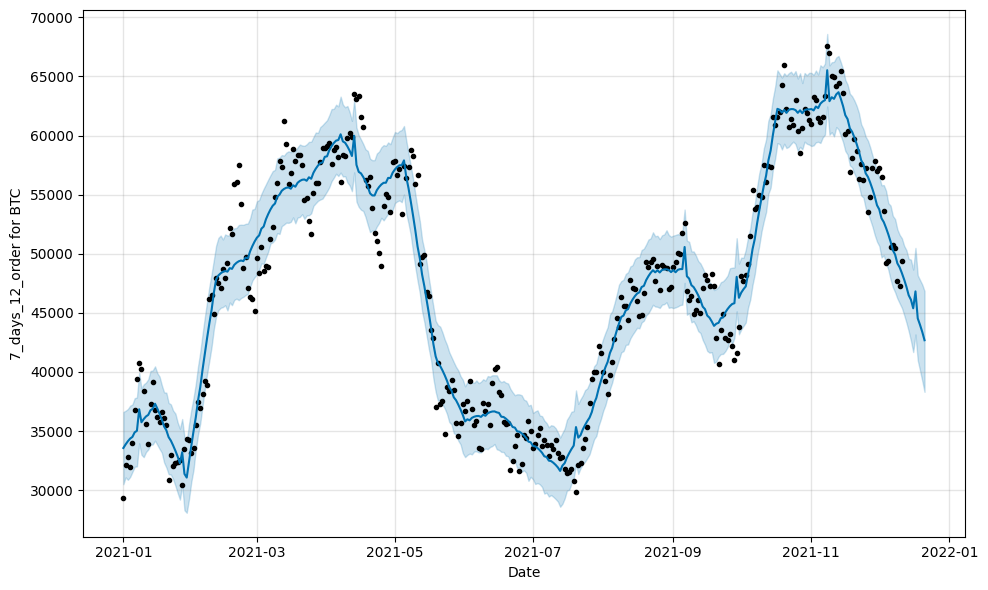

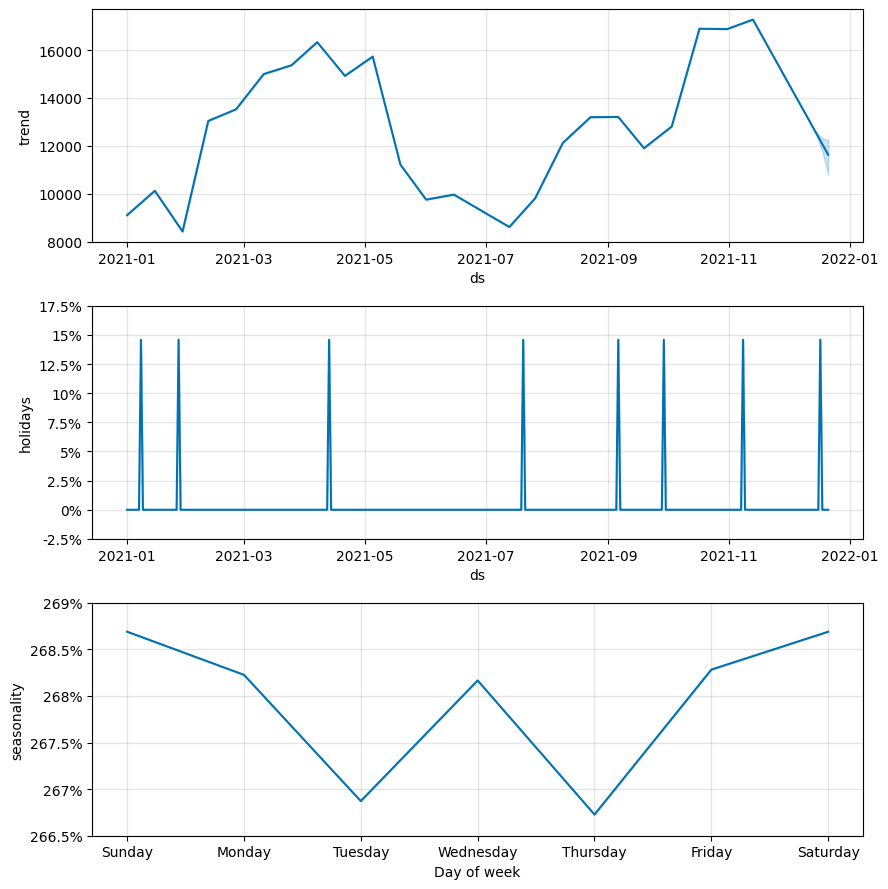

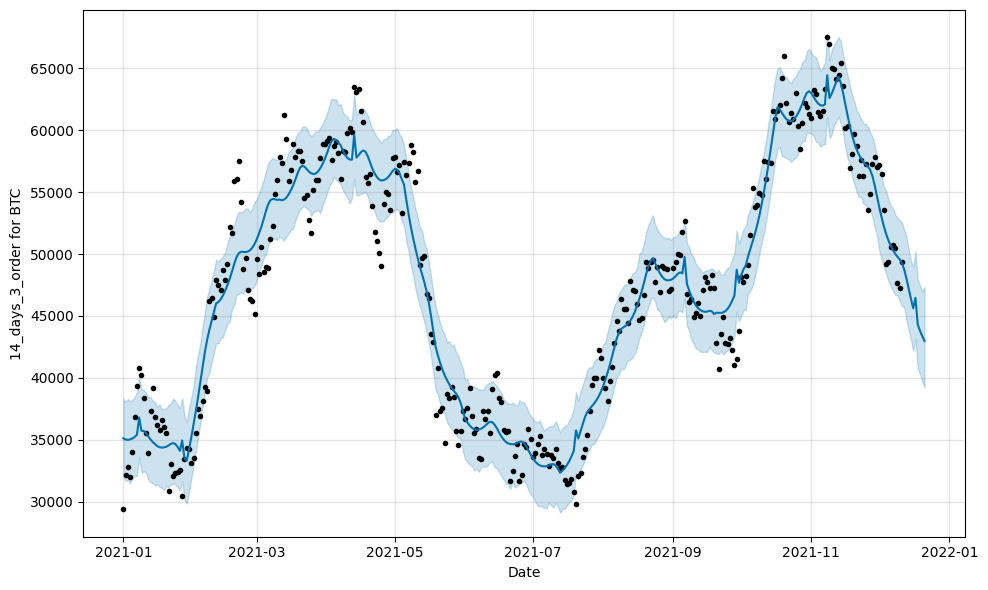

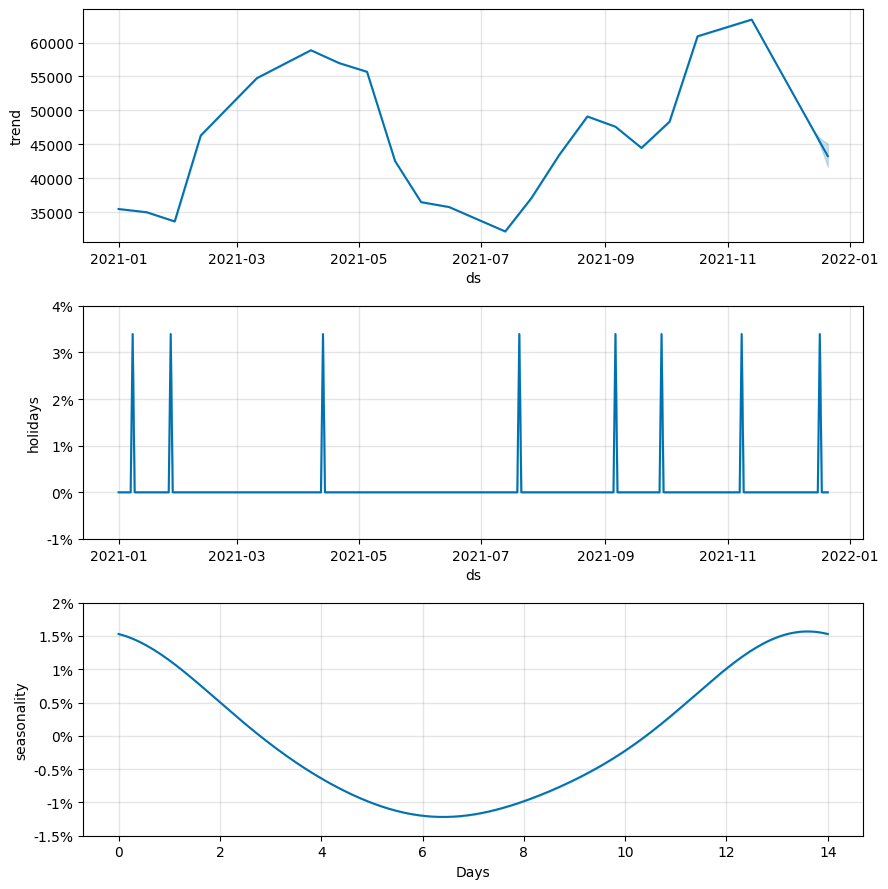

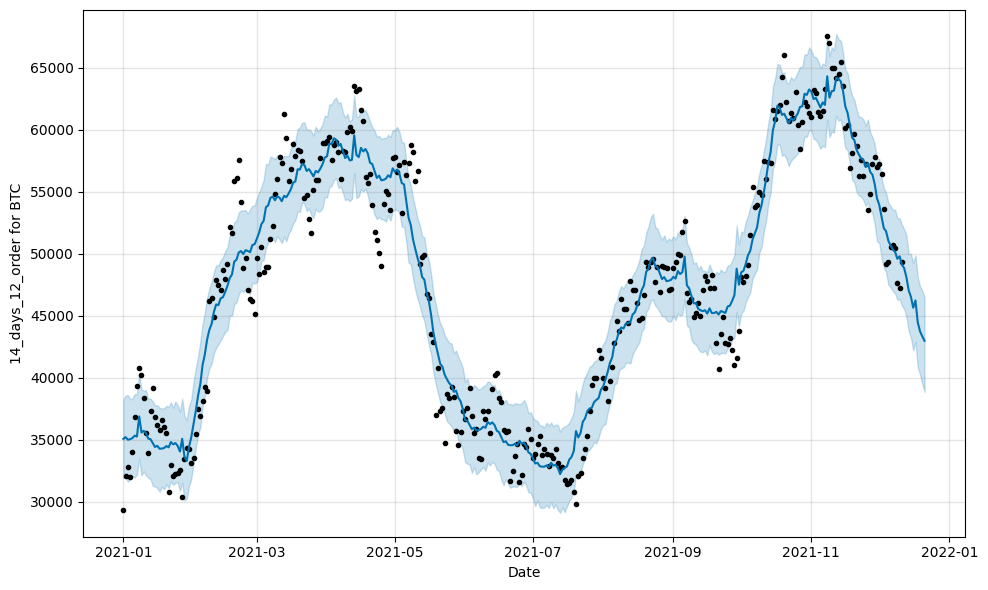

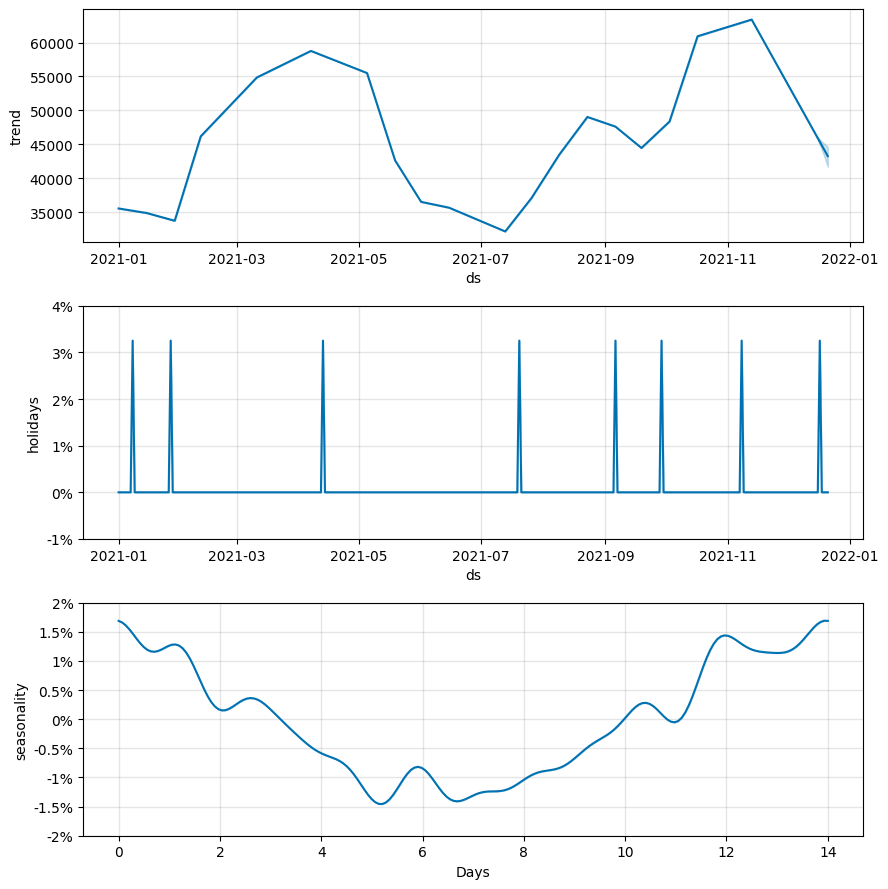

In [44]:
%%time
# Models tuning
if is_Prophet:
    for period_days in [4, 5, 7, 14]:
        for fourier_order_seasonality in [3, 12]:
            result, _ = prophet_modeling(result, 
                                         cryptocurrency, 
                                         train_ts, 
                                         valid_ts, 
                                         holidays_df, 
                                         period_days,
                                         fourier_order_seasonality,
                                         forecasting_days,
                                         f'{period_days}_days_{fourier_order_seasonality}_order',
                                         'valid')

### 4.2. ARIMA

In [45]:
# Get datasets
if is_ARIMA:
    train_ts, valid_ts, test_ts, train_valid_ts = get_train_valid_test_ts(df2.copy(), forecasting_days, target='Close')

Origin dataset has 365 rows and 2 features
Get training dataset with 345 rows
Get validation dataset with 10 rows
Get test dataset with 10 rows


In [46]:
def acf_pacf_draw(df, lag_num=40, acf=True, pacf=True, title="", ylim=1):
    # Draw plots named title with ACF and PACF for dataframe df
    
    num_plots = 1+int(acf)+int(pacf)
    fig, ax = plt.subplots(1,num_plots,figsize=(12,6))
    ax[0].plot(df.values.squeeze())
    
    if acf:
        plot_acf(df.values.squeeze(), lags=lag_num, ax=ax[1])
        ax[1].set(ylim=(-ylim, ylim))
        
        if pacf:
            plot_pacf(df.values.squeeze(), lags=lag_num, ax=ax[2])
            ax[2].set(ylim=(-ylim, ylim))
        
    elif pacf:
        plot_pacf(df.values.squeeze(), lags=lag_num, ax=ax[1])
        ax[1].set(ylim=(-ylim, ylim))

    fig.suptitle(title)
    plt.show()

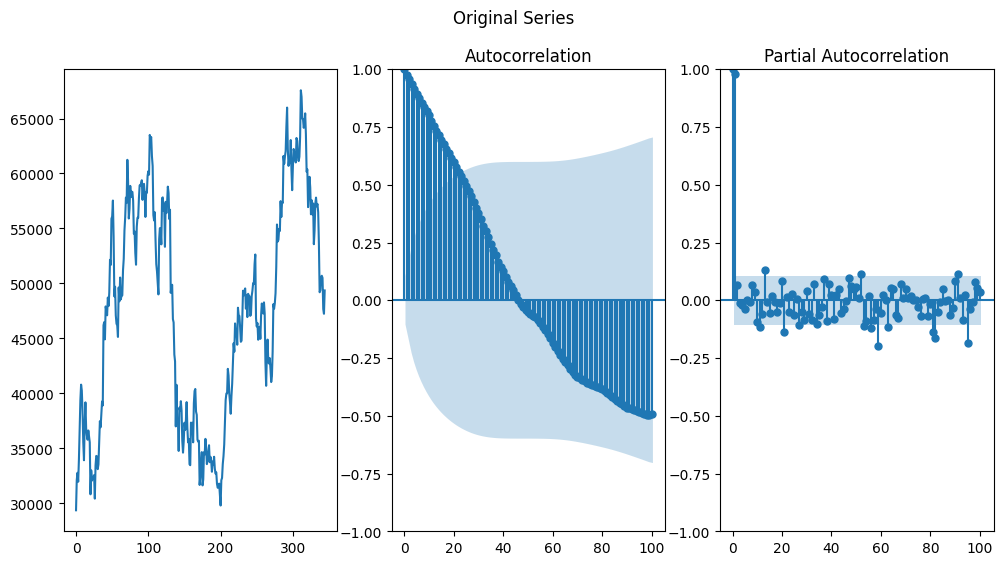

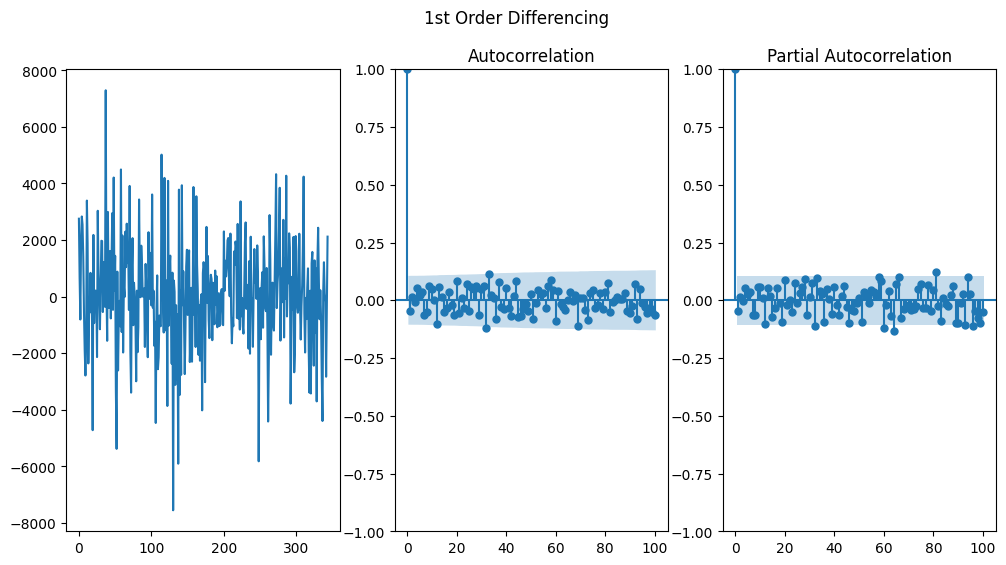

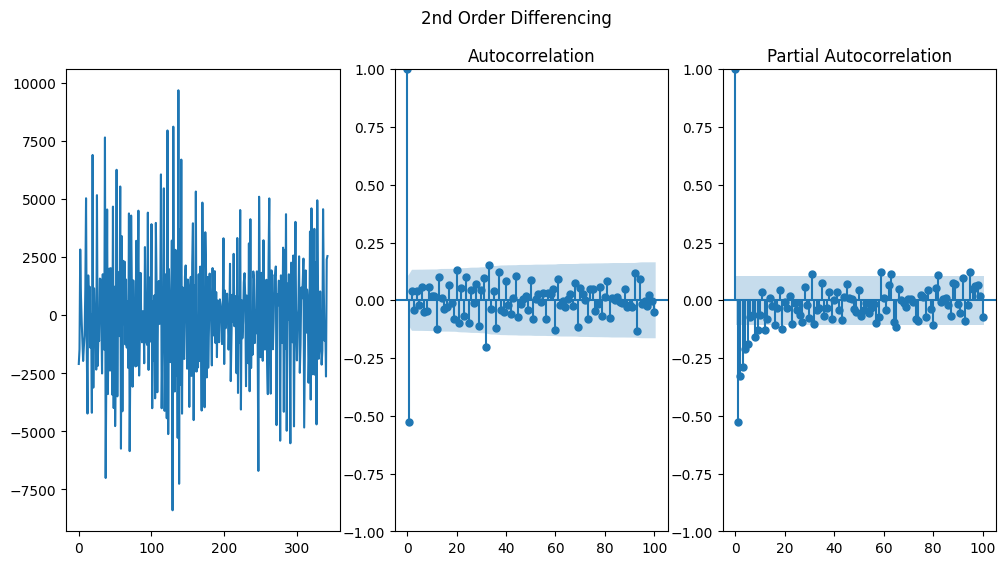

In [35]:
if is_ARIMA:
    # ACF and PACF
    lag_num = 100
    acf_pacf_draw(train_ts['y'], lag_num, True, True, 'Original Series')
    acf_pacf_draw(train_ts['y'].diff().dropna(), lag_num, True, True, '1st Order Differencing')
    acf_pacf_draw(train_ts['y'].diff().diff().dropna(), lag_num, True, True, '2nd Order Differencing')

In [47]:
def arima_fit(df, col, order=(1,1,1)):
    # ARIMA model fitting for series df[col]
    
    model = sm.tsa.arima.ARIMA(df[col].values.squeeze(), order=order)
    model = model.fit()
    return model

In [48]:
def get_residual_errors(model):
    # Calculation and drawing the plot residual errors for ARIMA model
    residuals = pd.DataFrame(model.resid)
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()

In [49]:
def arima_forecasting(result, model, params, name_model, df, type_data):
    # Data df (validation or test) forecasting on the num days by the model 
    # with params and save metrics to result 
    
    ypred = model.forecast(steps=len(df))
    
    n = len(result)
    result.loc[n,'name_model'] = name_model
    result.loc[n,'type_data'] = type_data
    result.at[n,'params'] = params
    result.at[n,'ypred'] = ypred
    #result = result_add_metrics(result, n, df['y'], y_pred)
    
    return result

In [51]:
%%time
if is_ARIMA:
    # Automatic tuning of the ARIMA model 
    model_auto = pm.auto_arima(train_ts['y'].values, 
                               start_p=4,        
                               start_q=4,        
                               test='adf',      
                               max_p=5, max_q=5,
                               m=1,             
                               d=None,           
                               seasonal=False,  
                               start_P=0,        
                               D=0, 
                               start_Q=0,
                               trace=True,
                               error_action='ignore',  
                               suppress_warnings=False, 
                               stepwise=True  )

    print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=6196.011, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6185.373, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6187.379, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6187.375, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6183.686, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6189.382, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.769 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  345
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3090.843
Date:                Mon, 26 Dec 2022   AIC                           6183.686
Time:                        07:25:43   BIC                           6187.527
Sample:                             0   HQIC                          6185.216
          

In [52]:
if is_ARIMA:
    # Get orders of the best model from AutoARIMA
    arima_orders_best = list(model_auto.get_params().get('order'))
    print(f"Optimal parameters are {arima_orders_best}")
    model_auto = arima_fit(train_ts, 'y', order=(arima_orders_best[0],arima_orders_best[1],arima_orders_best[2]))

Optimal parameters are [0, 1, 0]


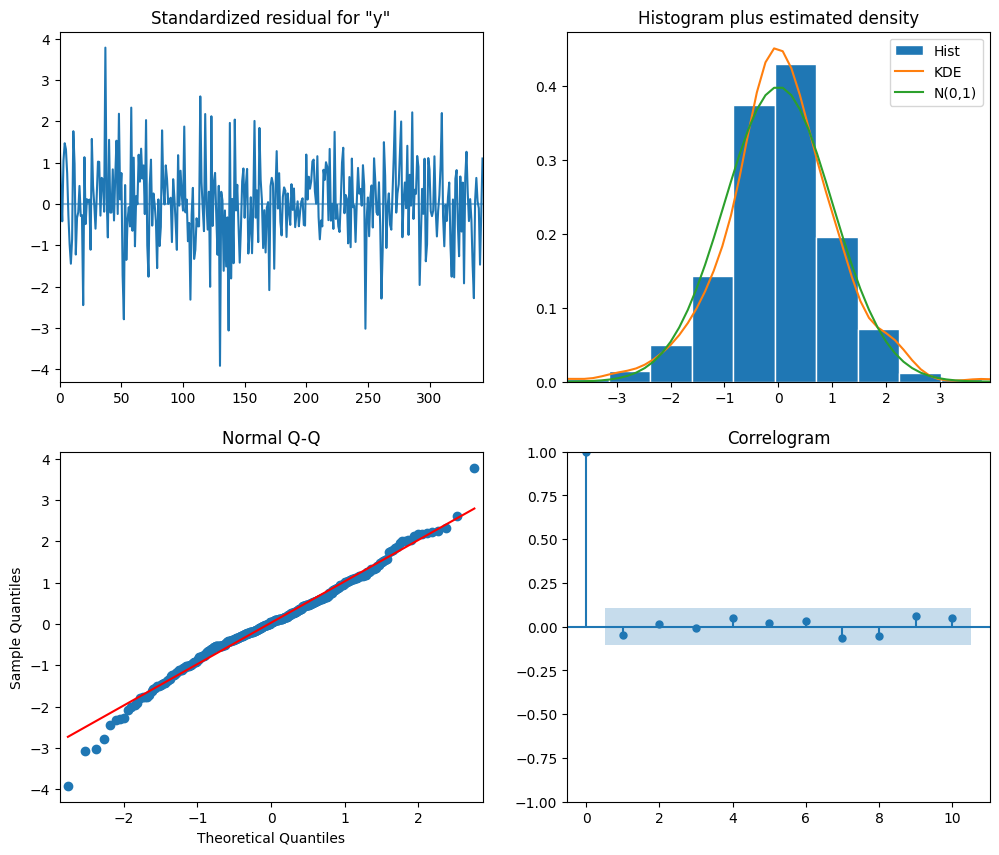

In [53]:
if is_ARIMA:
    # Best model from AutoARIMA
    fig = model_auto.plot_diagnostics(figsize=(12,10))
    plt.show()

- The residual errors seem fine with near zero mean and uniform variance.

In [54]:
if is_ARIMA:
    # Valid forecasting and save result
    result = arima_forecasting(result, model_auto, arima_orders_best, 'ARIMA_auto', valid_ts, 'valid')

### 4.3. Other ML models

In [55]:
# Get datasets
if is_other_ML:
    df2 = get_target_mf(df2, forecasting_days, col='Close')
    train_mf, ytrain_mf, valid_mf, yvalid_mf, test_mf, ytest_mf, train_valid_mf, y_train_valid_mf, starting_point = \
                                    get_train_valid_test_mf(df2.copy(), forecasting_days, target='target')

Origin dataset has 355 rows and 176 features
Get training dataset with 335 rows
Get validation dataset with 10 rows
Get test dataset with 10 rows


#### **4.3.1. Set parameters for many models**

In [56]:
if is_other_ML:
    # Set parameters of models
    models = pd.DataFrame(columns = ['name', 'model', 'param_grid'])

    # Linear Regression
    n = len(models)
    models.loc[n, 'name'] = 'Linear Regression'
    models.at[n, 'model'] = LinearRegression()
    models.at[n, 'param_grid'] = {'fit_intercept' : [True, False]}


    # KNeighbors Regressor
    n = len(models)
    models.loc[n, 'name'] = 'KNeighbors Regressor'
    models.at[n, 'model'] = KNeighborsRegressor()
    models.at[n, 'param_grid'] = {'n_neighbors': [3, 5, 10, 20, 30],
                                  'leaf_size': [10, 20, 30]
                                 }

    # Support Vector Machines
    n = len(models)
    models.loc[n, 'name'] = 'Support Vector Machines'
    models.at[n, 'model'] = SVR()
    models.at[n, 'param_grid'] = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                                  'C': np.linspace(1, 15, 15),
                                  'tol': [1e-3, 1e-4]
                                 }

    # Linear SVC
    n = len(models)
    models.loc[n, 'name'] = 'Linear SVR'
    models.at[n, 'model'] = LinearSVR()
    models.at[n, 'param_grid'] = {'C': np.linspace(1, 15, 15)}


    # Random Forest Classifier
    n = len(models)
    models.loc[n, 'name'] = 'Random Forest Regressor'
    models.at[n, 'model'] = RandomForestRegressor()
    models.at[n, 'param_grid'] = {'n_estimators': [40, 50, 60, 80], 
                                  'min_samples_split': [30, 40, 50, 60], 
                                  'min_samples_leaf': [10, 12, 15, 20, 50],
                                  'max_features': ['auto'], 
                                  'max_depth': [3, 4, 5, 6]                   
                                 }

    # Bagging Classifier
    n = len(models)
    models.loc[n, 'name'] = 'Bagging Regressor'
    models.at[n, 'model'] = BaggingRegressor()
    models.at[n, 'param_grid'] = {'max_features': np.linspace(0.05, 0.8, 1),
                                  'n_estimators': [3, 4, 5, 6],
                                  'warm_start' : [False]
                                 }

    # XGB Classifier
    n = len(models)
    models.loc[n, 'name'] = 'XGB Regressor'
    models.at[n, 'model'] = xgb.XGBRegressor()
    models.at[n, 'param_grid'] = {'n_estimators': [50, 70, 90], 
                                  'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                  'max_depth': [3, 4, 5]
                                 }

    # MLP Classifier
    n = len(models)
    models.loc[n, 'name'] = 'MLP Regressor'
    models.at[n, 'model'] = MLPRegressor()
    models.at[n, 'param_grid'] = {'hidden_layer_sizes': [i for i in range(2,5)],
                                  'solver': ['lbfgs', 'sgd'],
                                  'learning_rate': ['adaptive'],
                                  'learning_rate_init': [0.001, 0.01],
                                  'max_iter': [1000]
                                 }
models

,name,model,param_grid
0,Linear Regression,LinearRegression(),"{'fit_intercept': [True, False]}"
1,KNeighbors Regressor,KNeighborsRegressor(),"{'n_neighbors': [3, 5, 10, 20, 30], 'leaf_size..."
2,Support Vector Machines,SVR(),"{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'..."
3,Linear SVR,LinearSVR(),"{'C': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
4,Random Forest Regressor,RandomForestRegressor(),"{'n_estimators': [40, 50, 60, 80], 'min_sample..."
5,Bagging Regressor,BaggingRegressor(),"{'max_features': [0.05], 'n_estimators': [3, 4..."
6,XGB Regressor,"XGBRegressor(base_score=None, booster=None, ca...","{'n_estimators': [50, 70, 90], 'learning_rate'..."
7,MLP Regressor,MLPRegressor(),"{'hidden_layer_sizes': [2, 3, 4], 'solver': ['..."


#### **4.3.2. Models training and forecasting** 

In [57]:
def model_prediction(result, models, train_features, valid_features, train_labels, valid_labels):    
    
    def calc_add_score(res, n, type_score, list_true, list_pred, feature_end):

        res.loc[i, type_score + feature_end] = calc_metrics(type_score, list_true, list_pred)
        return res
    
    model_all = []

    for i in range(len(models)):
        # Training
        print(f"Tuning model '{models.loc[i, 'name']}'")
        model = GridSearchCV(models.at[i, 'model'], models.at[i, 'param_grid'])
        model.fit(train_features, train_labels)
        model_all.append(model)
        print(f"Best parameters: {model.best_params_}\n")
        
        # Prediction
        ypred = model.predict(valid_features)
        
        # Scoring and saving results into the main dataframe result
        n = len(result)
        result.loc[n,'name_model'] = f"{models.loc[i, 'name']}"
        result.loc[n,'type_data'] = "valid"
        result.at[n,'params'] = model.best_params_
        result.at[n,'ypred'] = ypred
        
    return result, model_all

In [58]:
%%time
if is_other_ML:
    # Models tuning and the forecasting
    result, model_all = model_prediction(result, models, train_mf, valid_mf, ytrain_mf, yvalid_mf)

Tuning model 'Linear Regression'
Best parameters: {'fit_intercept': False}

Tuning model 'KNeighbors Regressor'
Best parameters: {'leaf_size': 10, 'n_neighbors': 30}

Tuning model 'Support Vector Machines'
Best parameters: {'C': 1.0, 'kernel': 'linear', 'tol': 0.001}

Tuning model 'Linear SVR'
Best parameters: {'C': 6.0}

Tuning model 'Random Forest Regressor'
Best parameters: {'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 50}

Tuning model 'Bagging Regressor'
Best parameters: {'max_features': 0.05, 'n_estimators': 5, 'warm_start': False}

Tuning model 'XGB Regressor'
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}

Tuning model 'MLP Regressor'
Best parameters: {'hidden_layer_sizes': 2, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 1000, 'solver': 'lbfgs'}

Wall time: 8min 20s


### 4.4. Choosing the main optimal model and forecasting

In [59]:
def recovery_prediction(y, starting_point):
    
    return np.insert(y, 0, starting_point).cumsum()[1:]

In [60]:
def result_recover_and_metrics(result, df_ts, type_data, start_points):

    for i in range(len(result)):
        if (result.loc[i, 'type_data']==type_data) and (result.loc[i, 'mape'] is np.nan):
            ypred = result.loc[i, 'ypred']

            if not (str(result.loc[i, 'type_model']) in ['Prophet', 'ARIMA']):
                start_point_value = start_points['valid_start_point'] if type_data=='valid' else start_points['test_start_point']
                ypred = recovery_prediction(ypred, start_point_value)            

            result = result_add_metrics(result, i, df_ts['y'], ypred)
    
    return result

In [61]:
# Dispay and save all results for validation dataset
if len(result) > 0:
    
    result['type_model'] = result['name_model'].str.split('_').str[0]

    result = result_recover_and_metrics(result, valid_ts, 'valid', starting_point)
    display(result[['name_model', 'type_data', 'r2_score', 'rmse', 'mape']].sort_values(by=['type_data', 'mape', 'rmse'], ascending=True))
    
    num_models = len(result[result['type_data']=='valid']['name_model'].unique().tolist())
    print(f"Number of models built - {num_models}")
    result.to_csv(f'result_of_{num_models}_models_for_forecasting_days_{forecasting_days}.csv')
else: 
    print('There are no tuned models!')

,name_model,type_data,r2_score,rmse,mape
13,Random Forest Regressor,valid,-1.346028,1891.441239,3.609293
15,XGB Regressor,valid,-1.681957,2022.330814,3.910245
8,ARIMA_auto,valid,-2.134046,2186.144947,4.155419
0,Prophet_4_days_3_order,valid,-3.449163,2604.746267,4.364394
4,Prophet_7_days_3_order,valid,-3.306216,2562.560756,4.367898
2,Prophet_5_days_3_order,valid,-3.321019,2566.961548,4.415723
12,Linear SVR,valid,-2.594311,2341.176223,4.519983
11,Support Vector Machines,valid,-2.769858,2397.666229,4.646384
7,Prophet_14_days_12_order,valid,-3.943813,2745.72647,4.657357
6,Prophet_14_days_3_order,valid,-4.05536,2776.529648,4.802849


Number of models built - 17


In [62]:
def get_model_opt(name_model, params):
    # Model tuning for the name_model
    
    print(name_model)
    if name_model=='Linear Regression':
        model = LinearRegression(**params)
        
    elif name_model=='KNeighbors Regressor':
        model = KNeighborsRegressor(**params)
        
    elif name_model=='Support Vector Machines':
        model = SVR(**params)
        
    elif name_model=='Linear SVR':
        model = LinearSVR(**params)
        
    elif name_model=='Random Forest Regressor':
        model = RandomForestRegressor(**params)
        
    elif name_model=='Bagging Regressor':
        model = BaggingRegressor(**params)
    
    elif name_model=='MLP Regressor':
        model = MLPRegressor(**params)
        
    elif name_model=='XGB Regressor':
        model = xgb.XGBRegressor(**params)
        
    else: model = None
        
    return model

In [63]:
def get_params_optimal_model(result, main_metrics):
    # Get parameters of the optimal model from dataframe result by main_metrics

    result[main_metrics] = result[main_metrics].astype('float')
    
    opt_result = result[result['type_data']=='valid'].reset_index(drop=True)
    if main_metrics=='r2_score':
        opt_model = opt_result.nlargest(1, main_metrics)
    else:
        opt_model = opt_result.nsmallest(1, main_metrics)
    display(opt_model[['name_model', 'r2_score', 'rmse', 'mape', 'params']])

    opt_name_model = opt_model['name_model'].tolist()[0]
    opt_type_model = opt_model['type_model'].tolist()[0]
    opt_params_model = opt_model['params'].tolist()[0]
    print(f'Optimal model by metrics "{main_metrics}" is "{opt_name_model}" with type "{opt_type_model}" parameters {opt_params_model}')
    
    return opt_name_model, opt_type_model, opt_params_model

In [65]:
def model_training_forecasting(result, df, y, test, ytest,  
                               name_model, type_model, params, type_test='1'):
    
    if type_model=='Prophet':    
        season_days_optimal = params[0]
        fourier_order_seasonality_optimal = params[1]
        model_opt = None
        _, ypred = prophet_modeling(result, 
                                    cryptocurrency, 
                                    df, 
                                    test, 
                                    holidays_df, 
                                    season_days_optimal,
                                    fourier_order_seasonality_optimal,
                                    forecasting_days,
                                    f'{type_model}_optimal',
                                    'test')        
    elif type_model=='ARIMA':
        season_days_optimal = params[0]
        fourier_order_seasonality_optimal = params[1]        
        model_opt = None
        
        df['y'] = y
        model_opt = arima_fit(df, 'y', order=(params[0],params[1],params[2]))        

        fig = model_opt.plot_diagnostics(figsize=(12,10))
        plt.show()

        get_residual_errors(model_opt)

        ypred = model_opt.forecast(steps=len(test))        

    else:
        print(f"Tuning model '{name_model}'")
        models_opt_number = models[models['name']==name_model].index.tolist()[0]
        if type_test=='1':
            model_opt = GridSearchCV(models.at[models_opt_number,'model'], models.at[models_opt_number,'param_grid'])
        else:
            # type_test=='2'
            model_opt = get_model_opt(models.at[models_opt_number,'name'], params)
        model_opt.fit(df, y)
        
        ypred = model_opt.predict(test)

        
    n = len(result)-1
    result.loc[n,'name_model'] = f"{type_model}_optimal"
    result.loc[n,'type_data'] = "test"
    result.loc[n,'type_model'] = type_model
    result.at[n,'params'] = params
    result.at[n,'ypred'] = ypred
    
    return result, model_opt, ypred

In [66]:
def get_optimal_model_and_forecasting(result, main_metrics, start_points):
    
    if len(result) > 0:
        # Get parameters of the optimal model from dataframe result by main_metrics
        opt_name_model, opt_type_model, opt_params_model = get_params_optimal_model(result, 
                                                                                    main_metrics)
        if (opt_type_model=='Prophet') or (opt_type_model=='ARIMA'):
            train_valid = train_valid_ts.copy()
            y_train_valid = train_valid_ts['y'].copy()
            test = test_ts.copy()
            ytest = test_ts['y'].copy()
            
        else:
            train_valid = train_valid_mf.copy()
            y_train_valid = y_train_valid_mf.copy()
            test = test_mf.copy()
            ytest = ytest_mf.copy()
    
        result, model_opt, ypred = model_training_forecasting(result, train_valid, y_train_valid,
                                                              test, ytest,
                                                              opt_name_model, opt_type_model, 
                                                              opt_params_model, '1')
        
        result = result_recover_and_metrics(result, test_ts, 'test', start_points)
        
        if not ((opt_type_model=='Prophet') or (opt_type_model=='ARIMA')):
            ytest_plot = recovery_prediction(ytest.values, start_points['test_start_point'])
            ypred_plot = recovery_prediction(ypred, start_points['test_start_point'])
        else:
            ytest_plot = ytest.copy()
            ypred_plot = ypred.copy()
            
        plt.figure(figsize=(12,8))
        x = np.arange(len(ytest_plot))
        plt.scatter(x, ytest_plot, label = "Target test data", color = 'g', s=100)
        plt.scatter(x, ypred_plot, label = f"{opt_name_model} forecasting", color = 'r', s=50)
        plt.title(f'Forecasting of test data using the "{opt_name_model}" model, which is optimal for "{main_metrics}" metrics')
        plt.ylim(0)
        plt.legend(loc='lower right')
        plt.grid(True)
        
        return opt_name_model

,name_model,r2_score,rmse,mape,params
13,Random Forest Regressor,-1.346028,1891.441239,3.609293,"{'max_depth': 6, 'max_features': 'auto', 'min_..."


Optimal model by metrics "r2_score" is "Random Forest Regressor" with type "Random Forest Regressor" parameters {'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 50}
Tuning model 'Random Forest Regressor'


,name_model,r2_score,rmse,mape,params
13,Random Forest Regressor,-1.346028,1891.441239,3.609293,"{'max_depth': 6, 'max_features': 'auto', 'min_..."


Optimal model by metrics "rmse" is "Random Forest Regressor" with type "Random Forest Regressor" parameters {'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 50}
Tuning model 'Random Forest Regressor'


,name_model,r2_score,rmse,mape,params
13,Random Forest Regressor,-1.346028,1891.441239,3.609293,"{'max_depth': 6, 'max_features': 'auto', 'min_..."


Optimal model by metrics "mape" is "Random Forest Regressor" with type "Random Forest Regressor" parameters {'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 50}
Tuning model 'Random Forest Regressor'


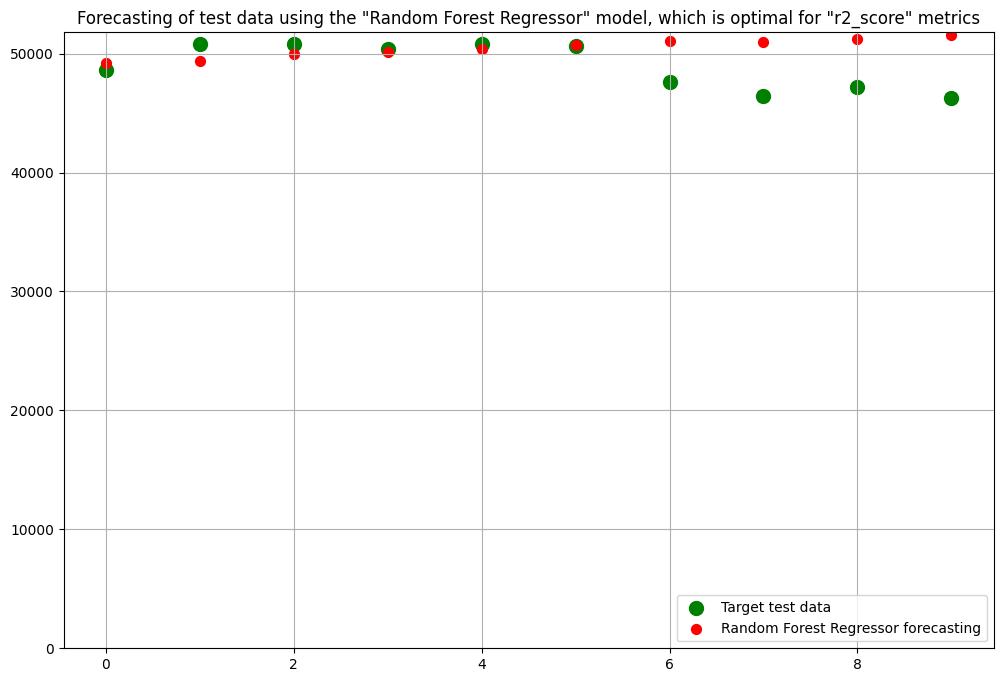

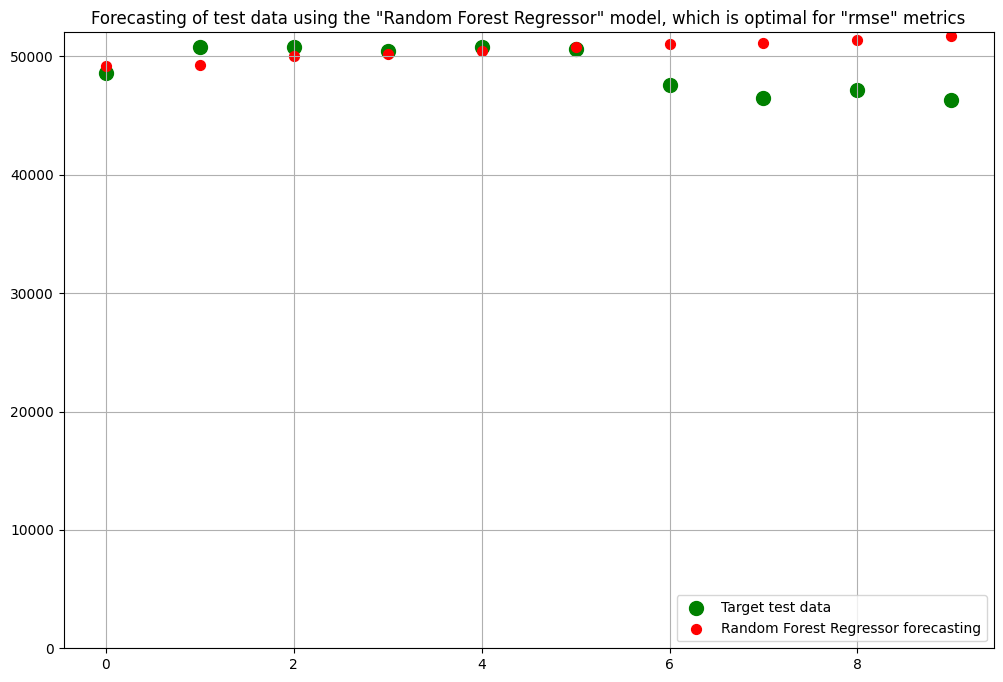

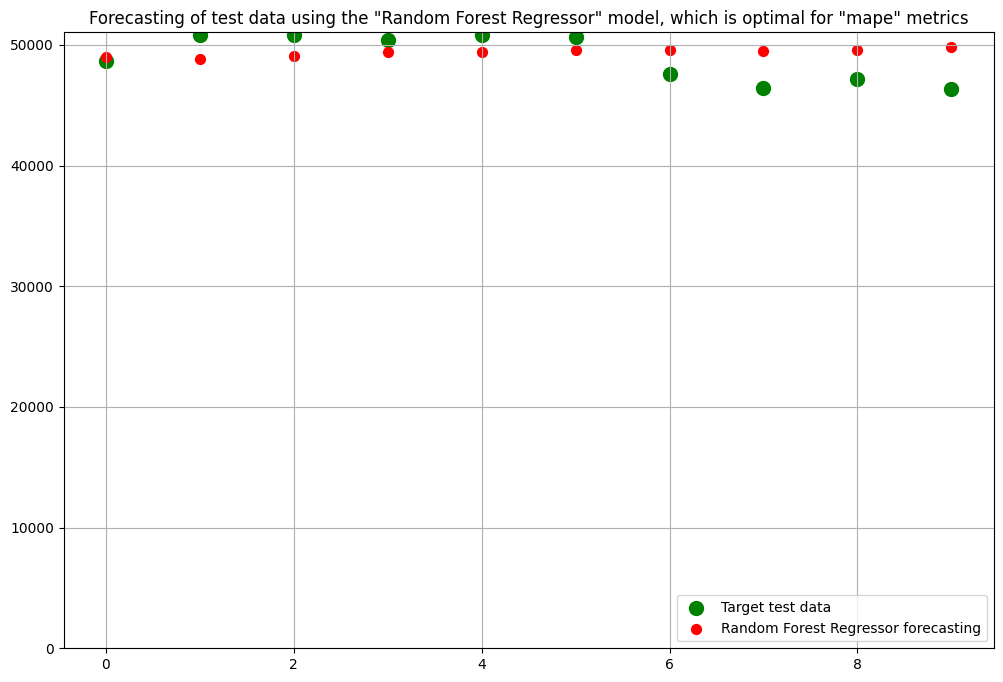

In [54]:
# Get the optimal model by different metrics
if len(result) > 0:
    for valid_metrics in ['r2_score', 'rmse', 'mape']:
        get_optimal_model_and_forecasting(result, valid_metrics, starting_point)    